In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv')
holidays = pd.read_csv('holidays_events.csv')

# Data Cleaning

In [3]:
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])

In [4]:
oil['dcoilwtico'].interpolate(method='linear', inplace=True)

In [5]:
train = pd.merge(train, stores, on='store_nbr', how='left')
train = pd.merge(train, oil, on='date', how='left')
train = pd.merge(train, holidays, on='date', how='left')

# Feature Engineering

In [6]:
train['day'] = train['date'].dt.day
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek

In [7]:
train['is_holiday'] = train['type_y'].isin(['Holiday', 'Event']).astype(int)
train['is_weekend'] = (train['day_of_week'] >= 5).astype(int)

In [8]:
train['sales_7d_avg'] = train['sales'].rolling(window=7).mean()
train['sales_30d_avg'] = train['sales'].rolling(window=30).mean()
train['sales_7d_std'] = train['sales'].rolling(window=7).std()

# Exploratory Data Analysis (EDA)

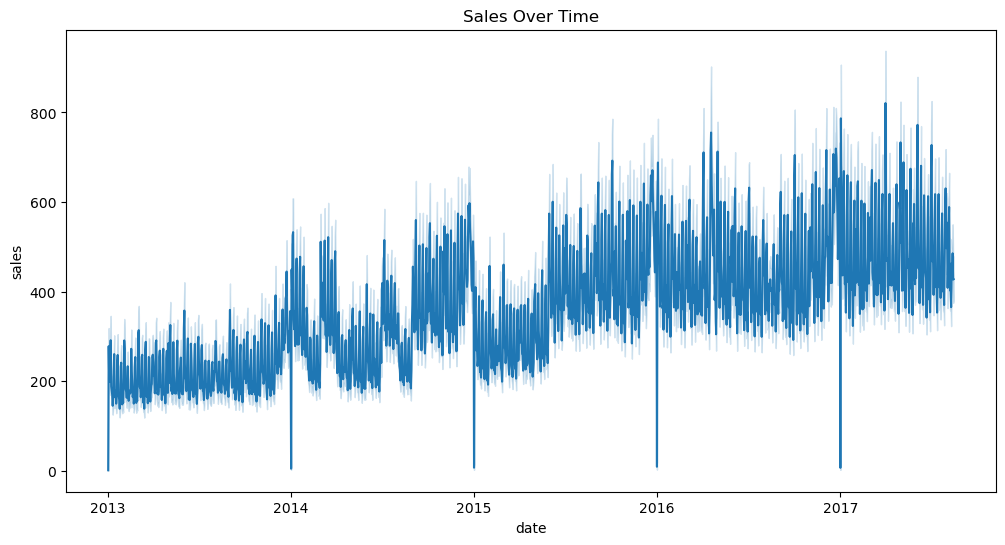

In [9]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='sales', data=train)
plt.title('Sales Over Time')
plt.show()

# Train-Test Split

In [10]:
from sklearn.model_selection import train_test_split
X = train.drop(columns=['sales', 'date'])
y = train['sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
print(train.isnull().sum())

id                     0
date                   0
store_nbr              0
family                 0
sales                  0
onpromotion            0
city                   0
state                  0
type_x                 0
cluster                0
dcoilwtico        880308
type_y           2551824
locale           2551824
locale_name      2551824
description      2551824
transferred      2551824
day                    0
month                  0
year                   0
day_of_week            0
is_holiday             0
is_weekend             0
sales_7d_avg           6
sales_30d_avg         29
sales_7d_std           6
dtype: int64


In [13]:
threshold = 0.3  # 30% missing values
train = train.loc[:, train.isnull().mean() < threshold]
print("Remaining Columns:", train.columns)

Remaining Columns: Index(['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city',
       'state', 'type_x', 'cluster', 'dcoilwtico', 'day', 'month', 'year',
       'day_of_week', 'is_holiday', 'is_weekend', 'sales_7d_avg',
       'sales_30d_avg', 'sales_7d_std'],
      dtype='object')


In [15]:
print("Missing Values:", train.isnull().sum().sum())

Missing Values: 880349


In [16]:
from sklearn.model_selection import train_test_split

# Assuming 'sales' is the target variable
X = train.drop(columns=['sales', 'date'], errors='ignore')
y = train['sales']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


## 2) One-Hot Encoding (For Few Categories)

In [19]:
import pandas as pd

# Perform One-Hot Encoding
X = pd.get_dummies(train.drop(columns=['sales', 'date'], errors='ignore'))
y = train['sales']

print("Shape after One-Hot Encoding:", X.shape)

Shape after One-Hot Encoding: (3054348, 90)


## Label Encoding (For Many Categories)

In [21]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = train.select_dtypes(include=['object']).columns

# Apply Label Encoding
le = LabelEncoder()
for col in categorical_cols:
    train[col] = le.fit_transform(train[col])

X = train.drop(columns=['sales', 'date'], errors='ignore')
y = train['sales']

print("Encoded Data Shape:", X.shape)

Encoded Data Shape: (3054348, 18)


## Models

## 1) Baseline Model (Naïve Forecasting)

In [22]:
y_pred_baseline = X_val['sales_7d_avg'].fillna(y_train.mean())
from sklearn.metrics import mean_squared_error, mean_absolute_error
print("Baseline RMSE:", np.sqrt(mean_squared_error(y_val, y_pred_baseline)))

Baseline RMSE: 973.1805130918722
